In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils import data
from TinyImageNet import TinyImageNet
from tensorboardX import SummaryWriter
from torch.autograd import Variable


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
from utils import show_images_horizontally
from NaiveResNet import NaiveResNet

In [3]:
%reload_ext autoreload
%autoreload 2

## 步驟
- 讀取資料集
- 簡單 EDA
    - facets
- 定義目標 / loss function
- 定義模型
- 訓練模型
- 測試模型
- 視覺化 kernels / parameters

## 前處理資料
- 讀取資料
- 轉換（灰階處理、Augmentation、Crop）

注意在 validation 時我們不需要做 augmentation

In [4]:
root = 'dataset'

In [5]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].
# normalize 在現在有 batch-normalization 的情況下其實非必要
normalize = transforms.Normalize((.5, .5, .5), (.5, .5, .5))

augmentation = transforms.RandomApply([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64)], p=.8)

training_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    augmentation,
    transforms.ToTensor(),
    normalize])

valid_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
    normalize])

將圖片全讀到記憶體，最小化硬碟 overhead

In [6]:
in_memory = False

In [7]:
%%time
training_set = TinyImageNet(root, 'train', transform=training_transform, in_memory=in_memory)
valid_set = TinyImageNet(root, 'val', transform=valid_transform, in_memory=in_memory)

CPU times: user 410 ms, sys: 76.4 ms, total: 486 ms
Wall time: 487 ms


In [8]:
training_set

Dataset TinyImageNet
    Number of datapoints: 100000
    Split: train
    Root Location: ./dataset
    Transforms (if any): Compose(
                             Lambda()
                             RandomApply(
                             p=0.8
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                         )
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

## 顯示處理後圖片
主要是顯示經過 data augmentation 的圖片。為了讓模型更 robust，我們隨機進行水平翻轉、剪裁以及旋轉的處理。在這邊顯示的圖有進行反正規化（un-normalization）。

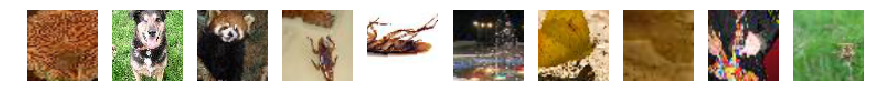

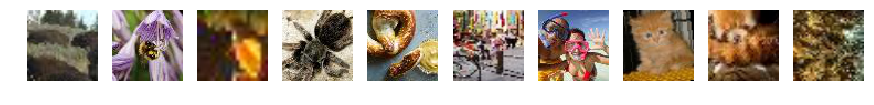

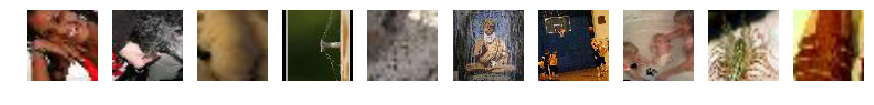

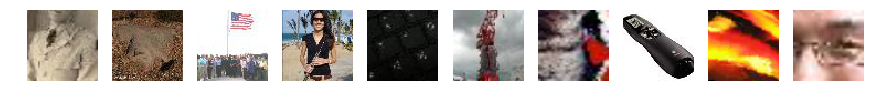

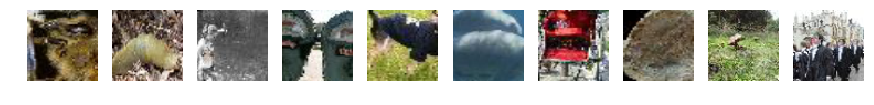

In [9]:
tmpiter = iter(data.DataLoader(training_set, batch_size=10, shuffle=True))
for _ in range(5):
    images, labels = tmpiter.next()
    show_images_horizontally(images, un_normalize=True)

## 定義 loss function

In [10]:
ce_loss = torch.nn.CrossEntropyLoss()

## 建立模型

In [11]:
resnet = NaiveResNet(num_classes=200)
device = torch.device("cuda")
resnet = resnet.to(device)

/home/meng/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 GeForce GT 750M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [12]:
# dummy_input = Variable(torch.rand(16, 3, 64, 64)).to(device)
# out = resnet.forward(dummy_input)
# out.size()

將模型圖寫到 Tensorboard 以供確認

In [13]:
# with SummaryWriter(comment='NaiveResNet') as w:
#     w.add_graph(resnet, (dummy_input, ))

## 定義 Optimizer

In [14]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

## 訓練模型

In [15]:
params = {'batch_size': 16, 'shuffle': True, 'num_workers': 1}
# params = {'batch_size': 2, 'shuffle': True, 'num_workers': 1}
max_epochs = 1

In [16]:
trainloader = data.DataLoader(training_set, **params)
validloader = data.DataLoader(valid_set, **params)

In [26]:
%%time
import time
assert torch.cuda.is_available()
try:
    for epoch in range(max_epochs):

        start = time.time()
        epoch_loss = 0.0
        
        resnet.train()
        for idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = resnet(data)
            batch_loss = ce_loss(output, target)
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()

#             if idx % 1 == 0:
#                 break
            
            if idx % 10 == 0:
                print('{:.1f}% of epoch'.format(idx / float(len(trainloader)) * 100), end='\r')
            
            
        # validation
        num_hits = 0
        num_instances = len(valid_set)
        
        resnet.eval()
        for idx, (data, tartget) in enumerate(validloader):
            data, target = data.to(device), target.to(device)
            output = resnet(data)
            _, pred = torch.max(output, 1) # output.topk(1) *1 = top1

            num_hits += (pred == target).sum().item()
            print('{:.1f}% of validation'.format(idx / float(len(validloader)) * 100), end='\r')
            
        print(f'{num_hits / num_instances * 100}%')
            
                
                
        epoch_loss /= len(trainloader)
        print("Time used in one epoch: {:.1f}".format(time.time() - start))
        
        break
        
except KeyboardInterrupt:
    print("Interrupted. Releasing resources...")
    
finally:
    torch.cuda.empty_cache()

        

0.33% of validation
Time used in one epoch: 7892.6
CPU times: user 1h 26min 1s, sys: 45min 29s, total: 2h 11min 31s
Wall time: 2h 11min 32s


In [28]:
10000 * 0.0033

33.0

In [18]:
print("YOOOOOOOO")

YOOOOOOOO


In [23]:
5 // 3

1